農研機構メッシュ農業気象データシステム(AMGSDS) 　ドキュメント<br>
チュートリアル　８ 発育の予測

# 発育の予測
 農作物は、芽が出る、花が咲く、実が熟すなど、段階（フェノロジー）を踏んで成長します。農作物につく虫も、孵化する、脱皮するなどまた然りです。このチュートリアルでは、気象データから、このような生物の発育を予測する方法を学びます。

　以下のセルを実行し、このチュートリアルで使用するライブラリを読み込んでください。<br>

**注意：** このチュートリアルでは、図に日本語を表示させます。文字化けを防ぐため、AMD_Tools4.pyの92行目または93行目のコメントアウトを外してない方は、外してからライブラリーを読み込んでください。

In [1]:
# このチュートリアルで使用するライブラリ

import numpy as np
import pandas as pd
import xarray as xr
import AMD_Tools4 as amd

## 1 DVR/DVS法
　農業現場で行われる発育予測の殆どは、**DVR/DVS法** で行われています。これは、作物や害虫の発育を以下の考え方で予測するものです。良く知られる **積算気温法** もこれに含まれます。

1. 生物は、日々発育する
1. 日々の発育の速度（これを **DVR** と呼ぶ）は、周囲の気温等、気象量の関数で与えることができる
1. 出穂のような生物の現象は、日々の発育を積算したもの（これを **DVS** と呼ぶ）の値が一定値に達したときに生起する
1. 同じ現象であっても、発育速度は種・品種によって異なる



## 2 発育速度関数
　生物の発育の活発さを気象量の関数で表現したものが **発育速度関数(DVR関数)** です。様々な生物の様々な現象に対応するため、数種類の基本的な関数と数個の調整係数(パラメータ)を組み合わせて使われます。一般的には、「水稲の出穂」や「カイガラムシの孵化」などの生命現象毎に、それに適した関数を設定し、品種や種などに対してパラメータを設定するという使い方がされます。
　ところで、**DVR** は、あくまで、仮想的な量なので値自体に意味はありません。このため、無次元化して「DVSが1になったら出穂である」など、１や２などの切りのよい数字が与えられることがあります。これは、水稲など生理が大きく変わり DVR 関数を切り替えなければならないような生物においてよく行われます。<br>
　これに対し、昆虫などは、孵化、1齢幼虫、2齢幼虫、・・、羽化、産卵など、フェノロジーが多い一方で、 DVR関数には同じものが適用可能です。このような生物に対しては、DVRの値を無次元化せずにそのままフェノロジーの変化点の指標として使う方が普通です。

　以下に、DVR 関数とその Python スクリプトをいくつか示します。発育速度関数は、このほかにも数多く提案されており、気象情報に加え**日長** も使用するものもあります。

#### 例１ 到達値を1とする有効積算気温法の DVR 関数

　有効積算気温法とは、一定の **基準温度(発育ゼロ点)** を超える温度を日々積算し、その値が **固有の積算値(到達積算温度)** に達したときに生命現象が起きるとする考え方です。積算気温を到達積算温度で除して無次元化し、１となったときに生命現象が生起するとする DVR 関数で表現することが可能です。このスクリプトを下に示します。ここでは、10.0 度と 1000.0 度がパラメータのデフォルト値として設定されています。
 
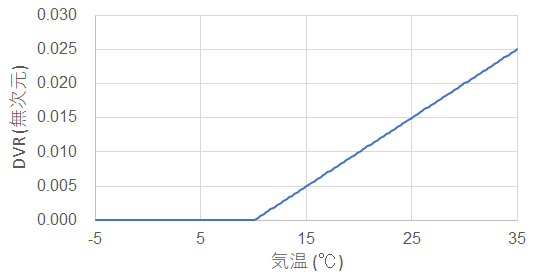

　この関数は以降の章で使用するので、「実行」して利用可能としてください。

In [2]:
# １ 有効積算気温法と等価なDVR関数

def DVR(Ta, Para=[10.0, 1000.0]):
    '''
    積算温度型の発育速度関数。
    引数(必須)：
      Ta：日平均気温
    引数(必要に応じ設定)  
      Para:基準温度(「発育ゼロ点」とも、これ以下の場合積算をしない) と 出穂到達積算温度 
    　　　　のリスト。デフォルト値として[10, 1000]が設定されている。
    戻り値：気温に対する発育速度値
    '''
    if Para[0] < Ta:
        DVR = (Ta-Para[0])/Para[1] #（平均気温ー基準温度）/出穂到達積算温度
    else:
        DVR = 0.0
    return DVR 

#### 例２ 発育と環境温度を折れ線で関係づける DVR 関数

　より複雑に、①ある温度以下では発育しない、②それより高い温度範囲では高ければ高いほど早く発育する。③さらに高い温度範囲では、発育の早さは頭打ちとなり一定、④もっと高い温度範囲では、温度が高くなると逆に発育が遅くなる。⑤それよりもさらに気温が高いと発育しない。という、台形のような折れ線の DVR 関数もしばしば用いられます。<br>
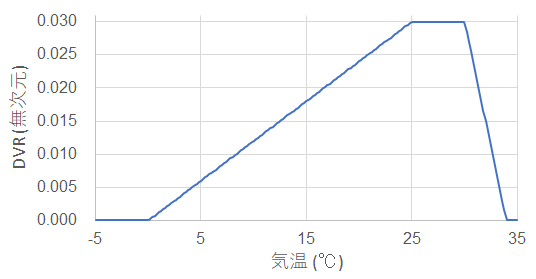

　このような DVR 関数は、Pythonでは、if 文を用いて下のように記述することが可能です。４つの特徴点をパラメータとして与え、各折れ線がそれらでうまく繋がるようにコーディングすることも可能ですが、このように決め打ちで書かれることが多いです。

In [3]:
# ２ 連結する折れ線で表現されるDVR関数

def DVR_(Ta):
    '''
    連結する折れ線で表現される発育速度関数
    このタイプは、品種特性込みの実験式として作成されることが多い。
    これは、5本の折れ線で構成される場合のサンプル。 elif文を増やせば
    折れ線の数を増やすことができる。
    引数(必須)：
      Ta：日平均気温
    戻り値：気温に対する発育速度値
    '''
    if Ta <= 0:
        return 0.0
    elif Ta <= 25.0 :
        return 0.0012 * Ta
    elif Ta <= 30.0 :
        return 0.03
    elif Ta <= 34.0:
        return 0.03-0.0075 * (Ta-30)
    else:
        return 0.0


#### 例３ 三角法の DVR 関数

　気温は時刻により変動するので、日平均気温としては基準温度(成長ゼロ点)を下回っていても、昼間の数時間はそれを上回るような状況は普通に起こります。有効積算気温法におけるパラメータはこのような状況も織り込んで定められますが、発育速度が温度帯によって明瞭に異なる昆虫等では、"状況を織り込む" やり方ではなかなか精度よく推定ができません。<br>
　精度を向上させるには時別気温等、時間分解能が高い気象データを使用することが最も合理的ですが、メッシュ農業気象データが提供する時別気温は９日先までなので、これを超える未来について予測をするときには、日別気象データでの予測が求められます。このようなときには、**三角法** (坂神・是永 1981)を利用するのが次善の策として適切です。三角法は、気温の時別値がそう簡単には入手できなかった時代に開発された方法で、気温の日変化が０時の日最低気温、8時の日最高気温、24時の翌日の日最低気温を結ぶ折れ線の形で起きると仮定し、生物毎に定められた **発育下限温度**、**発育上限温度**、**発育停止温度** がこの折れ線を三角形や台形で切り取る部分の面積に比例して発育するとするものです。

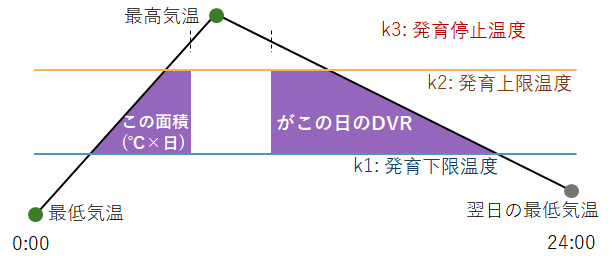

　三角法の DVR 関数のコーディングは、厳密には、線分で囲まれた図形の面積を場合分けをしながら幾何学的に解き、それらを足し合わせる形で行いますが、シミュレーションのような方法で近似値を簡単に計算することも可能です。以下にその例を示します。この関数は後に使用するので、「実行」して利用可能としてください。

　なお、幾何学的に厳密に解く発育速度関数は、ライブラリ **AMD_ETcalc** の関数 **ET_triangle** で提供されているので、必要な方はメッシュ農業気象データ利用者専用ページから入手の上、利用規約に従って利用してください。

In [4]:
import numpy as np
def DVR3(Tmin, Tminn, Tmax, k1=10.0, k2=25.0, k3=99.0):
    '''
    生物の発育を三角法(坂神・是永:1981)から推定する方法
    Tmin: ある日の最低気温
    Tminn: 翌日の最低気温
    Tmax: ある日の最高気温
    k1: 発育下限温度（celsius度）
    k2: 発育上限温度（celsius度）
    k3: 発育停止温度（celsius度）
    '''
    div = 12 # 解析的な方法に近づけたい場合はこの値を大きくする
    h = np.zeros(24*div)
    h[:8*div] = np.linspace(Tmin, Tmax, 8*div,endpoint=False)
    h[8*div:] = np.linspace(Tmax, Tminn, (24-8)*div)
    h = np.where(h>=k3, k1, h)
    h = h.clip(k1, k2) - k1
    return h.sum()/(24*div)


## 3 発育計算の基本形
　DVR/DVS法を用いた発育予測のプログラミングを理解するために、以下の条件で水稲の出穂日を予測してみます。
* DVR関数に有効積算気温型を用いる
* 基準温度は10℃、積算温度は1050℃・日とする
* 北緯36.0566度、東経140.125度（茨城県つくば市内）で栽培されているとする
* 移植日は2024年5月10日とする

　理解の助けとするため、期間中の 気温、DVR、DVS の推移を下図に示します。
 
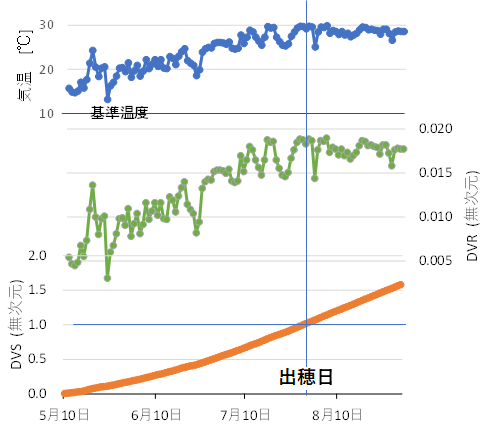

　まず、日平均気温を取得しましょう。移植日が5月10日なので、期間の開始日は5月10日にします。どんなに遅くとも9月じゅうには出穂するでしょうから、期間の終了日は9月30日とします。

In [5]:
# 気象データの取得
nani = 'TMP_mea'
itsu = ['2024-05-10', '2024-09-30']  # 移植日から、まあそれまでには出穂するでしょうという日まで
doko = [36.0566, 36.0566, 140.1250, 140.1250]
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)
Ta = data[:,0,0] 

TMP_mea (144, 1, 1) Tile


　次に、基本的設定として、DVR関数のパラメータ（基準温度と積算温度）を設定します。

In [6]:
# 基本的設定
para = [10.0, 1050.0]  # 基準温度は10℃、積算温度は1050℃・日

　「 i 日目の気温 Tai からその日の DVR を計算して DVS に加える 」という処理を、DVS が１を超えるまで繰り返すことで出穂日を予測します。

In [7]:
# 出穂の計算
DVS = 0.0
for i, Tai in enumerate(Ta):  # iに'日目'が、Taiにi日目の気温が順次渡される
    DVS += DVR(Tai,Para=para)   # i日目(が終わった時)におけるDVS
    print(f"{i}: {Tai:.1f}, {DVS}")
    if DVS > 1.0 : # DVSが1を超えたら
        break      # ループを終了
# 結果の表示
print('出穂日: ', tim[i])

0: 15.8, 0.005523809705461774
1: 19.1, 0.01419047673543294
2: 20.5, 0.02419047673543294
3: 18.7, 0.032476191747756226
4: 15.9, 0.0380952399117606
5: 18.5, 0.04619047800699869
6: 18.3, 0.0540952410016741
7: 19.9, 0.06352381206694102
8: 20.6, 0.07361905052548362
9: 20.0, 0.08314286004929314
10: 17.1, 0.0899047651745024
11: 21.1, 0.10047619410923547
12: 19.2, 0.10923809959774924
13: 20.3, 0.11904762449718656
14: 22.8, 0.13123810177757625
15: 19.9, 0.14066667284284318
16: 20.1, 0.15028572082519528
17: 21.9, 0.16161905379522412
18: 23.6, 0.17457143511090958
19: 20.1, 0.1841904830932617
20: 21.3, 0.19495238894507996
21: 17.8, 0.2023809614635649
22: 19.2, 0.21114286695207868
23: 17.5, 0.21828572409493582
24: 18.2, 0.22609524863106864
25: 18.4, 0.23409524826776415
26: 19.1, 0.24276191529773533
27: 20.5, 0.25276191529773534
28: 20.9, 0.2631428673153832
29: 21.2, 0.2738095347086589
30: 21.6, 0.2848571541195824
31: 20.1, 0.29447620210193454
32: 23.6, 0.30742858341761997
33: 24.0, 0.32076191675095

　このスクリプトでは、「 **i 日目の気温 Tai からその日の DVR を計算して DVS に加える** 」という処理を **for 文** で繰り返し行います。さらに、DVSの値を監視する if 文を for ブロック中に置いておき、DVS が 1 になったら for ブロックから強制的に抜け出すようにしています。<br>
　移植日（= **tim[0]** ）の気温データから繰り返し計算を進め、 i 番目の気温データで１を超えたのであれば、その日の日付は、**tim[i]** なので、これが出穂日となります。<br>

　Python の for 文では、**in** の右側に置いたイテレータ（順に要素を取り出せるタイプのもの、この場合は １次元配列 **Ta** ）の要素が順次 **in** の左側に置いた変数（この場合は **Tai** ）に代入されて for ブロックが実行されますが、イテレータを関数 **enumerate** に入れた形で置くと、要素だけでなく、そのインデックス（何番目の要素であるか）もループ内部で使用できるようになります。今回は、気温データだけでなく、出穂日を同定するためにインデックスも使用するので、この関数を使用しました。

　また、for 文は、本来は、指定された回数実行して円満に終了するためのものであり、このような使用法は少し邪道ですが、このようにすると、想定した時期になっても出穂しなかった場合に、与えた気象データの最後の日が出穂日として'円満'に返され、エラーが発生しません。発育予測に関しては、なまじエラーで停止するよりもこちらの方が何かと便利なので、敢えて for で繰り返し計算をさせています。

　なお、この例では、積算を開始する DVS の初期値を0と置きましたが、育苗条件に応じて0.1等に設定して予測することもあります。

## 4 発育の分布図
　農業現場では、各生産者の管理を支援する目的で、県下の水稲の出穂日や果樹の開花日の予測分布図を作成することがあります。このような例として、水稲の出穂日数(移植日からの日数)を、以下の条件で推定し分布図とするケースを考えます。
* 有効積算気温法（基準温度10℃、積算温度1050℃・日）で推定する
* 対象は、茨城県の水田が分布する３次メッシュ
* 移植日は、領域一律に2024年5月10日とする 

　面的な推定は、「 _3 発育計算の基本形_ 」で行ったのと同じ計算を、メッシュごとに何度も繰り返せば実行できますが、そのために、以下２項目の準備が必要です。
 
1.  計算対象とするメッシュのリストアップ
1. それぞれのメッシュにおける出穂日数を記録するための配列の用意

　ともあれ、気象データを取得します。

In [8]:
# 気象データの取得
nani = 'TMP_mea'
itsu = ['2024-05-10', '2024-09-30'] 
doko = [35.733,36.950, 139.690,140.860]  # 茨城県がすっぽり入る大きさ
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)

TMP_mea (144, 148, 94) Tile


　そして、１項目目は以下のようにします。

In [9]:
prf, lat, lon = amd.GetGeoData('pref_0800', doko) # 県域データ
lu01,lat, lon  = amd.GetGeoData('landuse_H210100', doko)  # 「田」の比率データ
pad = np.where(lu01>0.0, 1, np.nan)  # 田が少しでもあれば1,全くなければ無効値の配列
met = np.where( ~np.isnan(data[0,:,:]), 1, np.nan) # 気象データがあれば１なければ無効値の配列
val = prf * pad * met
yy,xx = np.where(val == 1) # 計算対象のインデックス(要素の番号)

print(yy)
print(xx)

pref_0800 (148, 94) Tile
landuse_H210100 (148, 94) Tile
[  3   3   4 ... 145 146 146]
[88 89 86 ... 72 70 71]


　「 _チュートリアル５ 地理情報の利用　4 地理情報等による処理対象メッシュの設定 例1_ 」の復習になりますが、上の yy と xx から１つずつ要素を取り出してそれぞれ緯度方向のインデックスと経度方向のインデックスとした配列要素が、計算対象のメッシュです。具体的には、[3,88]、[3,89]、[4,86]、・・・、[145,72]、[146,70]、[146,71] が計算対象のメッシュです。

　項目２については、以下のようにします。

In [10]:
# 出穂日数を記録するための配列を新規作成
hd = val * np.nan  # 手抜きの方法

　これでループ処理を組む材料が整いました。
 
　ループにおいては、インデックスの配列 **yy** と **xx** から１つずつ取り出して **Y** と **X** に代入し、それに基づいて処理対象のメッシュの気象データを1次元の形で取り出します。２個の変数を同時に取り出すので、for 文に関数 **zip** を用います。<br>
　このforループの中に、**DVR** を積算するためのforループをもう一段深く置きます。<br>
　DVS が1を超えてこのループを脱したらそのときの **i** (これが出穂日数)を **hd[Y,X]** に保存します。

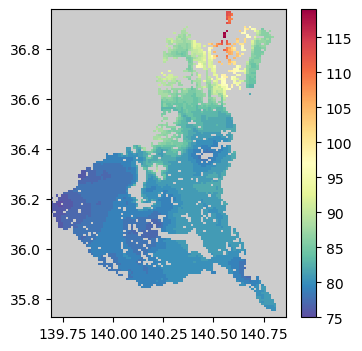

In [11]:
para = [10.0, 1050.0]  #基準温度は10℃、積算温度1050℃・日

for Y, X in zip(yy,xx):
    Ta = data[:,Y,X]  # メッシュ[Y,X]における全期間の気温
    #出穂日計算
    DVS = 0.0 #移植時の発育指数
    for i, Tai in enumerate(Ta):  # iに'日目'、Taiにi日目の気温が順次渡される
        DVS += DVR(Tai,Para=para)   # i日目(が終わった時)におけるDVS
        if DVS > 1.0 : #DVSが1を超えたら
            break
    hd[Y,X] = i
    
# 描画
amd.mapfig(hd,lat,lon)

## 5 発育の分布図（三角法）
　ヒメトビウンカという昆虫は、水稲の主要な病害の一つであるイネ縞葉枯病を媒介することから適切に防除する必要があります。薬剤が最も効果的に作用するのは孵化直後の1齢幼虫に対してですが、薬剤効果の持続期間も考慮し、営農上の適期は、卵として生み出された直後から1週間とされます。なお、関東地方において、ヒメトビウンカは4齢幼虫で越冬するので、このような防除適期（要防除期）は2回存在します。１回目は、第4齢で越冬に入った個体(第１世代)が成長して産卵(第２世代)したとき、２回目は、この第２世代が成長して産卵(第３世代)したときです。

　以下にヒメトビウンカの発育に関するデータを示します。

1. 三角法に必要なパラメータ
   *  発育ゼロ点(k1: これを下回る温度では成長しない)	11.0℃
   *  発育上限(k2: この温度で成長速度は頭打ちとなる)	29.0℃
   *  発育停止(k3: これを上回る温度では成長しない)	30.2℃
1. DVS 到達値
|発育|積算温度（℃・日）|発育|積算温度（℃・日）|
|----|----|----|----|
|卵→1齢幼虫|110.0|卵→1齢幼虫|110.0|
|1齢幼虫→2齢幼虫|40.5|卵→2齢幼虫|150.5|
|2齢幼虫→3齢幼虫|32.6|卵→3齢幼虫|183.1|
|3齢幼虫→4齢幼虫|35.5|卵→4齢幼虫|218.6|
|4齢幼虫→5齢幼虫|39.7|卵→5齢幼虫|258.3|
|5齢幼虫→成虫|61.7|卵→成虫|320.0|
|成虫→産卵|54.3|卵→卵|374.3|

　ここでは、２つある防除適期の開始日（第1世代の産卵期と第2世代の産卵期）を **三角法** で推定します。対象地域は埼玉県、年次は2023年としましょう。

　計算手順は、基本的に _第4章_ と同じです。ただし、このケースでは第1世代の産卵時期と、第2世代の産卵時期という２つの時期を予測するので、DVRを積算するforループが二つ設けられます。
 
　最初の準備として、**三角法のDVR関数** を利用可能としておいてください( _2 発育速度関数 例３_ の Code Cell を実行します)。<br>
 
　次の準備は、気象データの取得です。埼玉県では、４齢幼虫は脱皮後すぐ越冬に入り、かつ、この時期の気温は、発育ゼロ点をあまり上回らないので、予測に使用する気象データのスタート日は1月1日で大丈夫です。また、終わりは、余裕をみて9月30日としましょう。三角法では日最高気温と日最低気温が必要です。以下で気象データを取得します。

In [12]:
# 気象データの取得
itsu = ['2023-01-01', '2023-09-30'] 
doko = [35.750, 36.292, 138.702, 139.910]  # 埼玉県がすっぽり入る大きさ
datatn, tim, lat, lon = amd.GetMetData('TMP_min', itsu, doko)
datatx, tim, lat, lon = amd.GetMetData('TMP_max', itsu, doko)

TMP_min (273, 67, 97) Tile
TMP_max (273, 67, 97) Tile


　次に、「埼玉県域、かつ、気象データが存在するメッシュ」 を同定しましょう。「水田が少しでも存在」という条件を加えていないこと以外は _第4章_ と同じです。以下のようにして、条件を満たすメッシュのインデックス **yy** と **xx** に格納します。

In [13]:
prf, lat, lon = amd.GetGeoData('pref_1100', doko) # 県域データ
met = np.where( ~np.isnan(datatn[0,:,:]), 1, np.nan) # 気象データがあれば１なければ無効値の配列
val = prf * met
yy,xx = np.where(val == 1) # 計算対象のインデックス(要素の番号)

pref_1100 (67, 97) Tile


　計算を開始する前に、２つの防除の開始時期のインデックス(timの何番目の要素か)を記録する配列を用意します。これは、上の Code Cell で作った配列 **val** を使って下のようにすると簡便に作ることができます。

In [14]:
# 産卵日のインデックスを記録する配列を手抜きで作成
g1spw = val * np.nan  # 第1世代の産卵日
g2spw = val * np.nan  # 第2世代の産卵日

　計算結果の格納場所を用意したら、次に、ループを組み立てます。計算対象のメッシュの中に、第1世代の産卵日を推定するループと、第2世代の産卵日を推定するループを直列に並べます。それは、模式的に以下のようになります。
 
```python
for Y, X in zip(yy,xx):  # メッシュのループ

    Tmin = datatn[:,Y,X]  # メッシュ[Y,X]における全期間の気温を代入
    Tmax = datatx[:,Y,X]  # 　　〃
    # 第1世代の発育（4齢幼虫→卵）
    DVS = 218.6  # 卵→4齢幼虫は終わっている
    for t in range(len(Tmin)):  # 気温データの個数(数日)だけループ
        ＜DVRの積算＞

    g1spw[Y,X] = t  # 産卵日のインデックスを記録

    Tmin = datatn[t+1:,Y,X]  # 産卵日翌日以降の気温に置き直す
    Tmax = datatx[t+1:,Y,X]  # 　　〃
    # 第２世代の発育（卵→卵）
    DVS = 0  # 卵からなので0スタート
    for t2 in range(len(Tmin)):  # 残りの気温データの個数(数日)だけループ
        ＜DVRの積算＞
    
    g2spw[Y,X] = t2  # 産卵日のインデックスを記録
```

　DVR を積算するループも書き込んでみましょう。ここで、三角法は、ある日の最低気温、最高気温と、翌日の最低気温が必要となることに注意してください。

c:\Users\amilu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\amilu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\amilu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\amilu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\amilu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38450 (\N{CJK UNIFIED IDEOGRAPH-9632}) missing from font(s) DejaVu Sans.
  fig

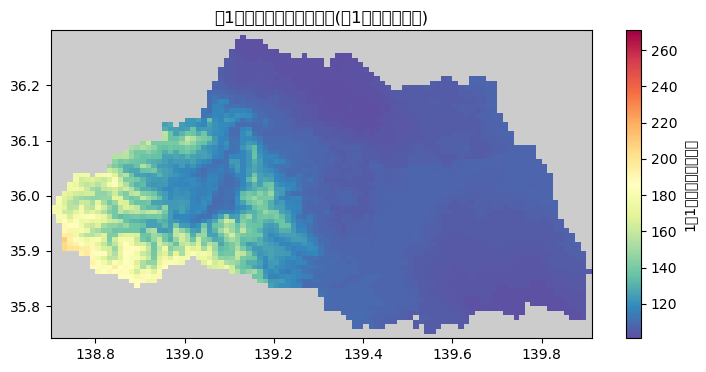

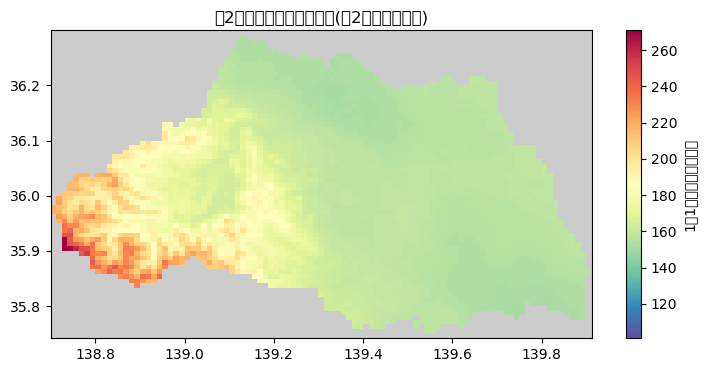

In [15]:
# 発育の計算
for Y, X in zip(yy,xx):
    #第1世代の発育
    Tmin = datatn[:,Y,X]  # メッシュ[Y,X]における全期間のデータ
    Tmax = datatx[:,Y,X]  # 　　　　〃
    DVS = 218.6  # 卵→4齢幼虫は終わっている
    for t in range(len(Tmin)-1):  # 翌日の最低気温が取得データからはみ出さないよう１小さくしておく
        DVS += DVR3(Tmin[t],Tmin[t+1],Tmax[t], k1=11.0, k2=29.0, k3=30.2)   # t日目(が終わった時)におけるDVS
        if DVS > 374.3 : #卵から卵のDVS
            break
    g1spw[Y,X] = t
    #第2世代の発育
    Tmin = datatn[t+1:,Y,X]  # メッシュ[Y,X]における産卵日翌日以降のデータ(インデックスが付け直されている)
    Tmax = datatx[t+1:,Y,X]  # 　　　　〃
    DVS = 0  # 卵からなので0スタート
    for t in range(len(Tmin)-1):  # ここのtは産卵翌日からの日数(ゼロ始まり)'
        DVS += DVR3(Tmin[t],Tmin[t+1],Tmax[t], k1=11.0, k2=29.0, k3=30.2)
        if DVS > 374.3 : #卵から卵のDVS
            break
    g2spw[Y,X] = g1spw[Y,X] + t + 1

# 予測結果の描画
mima = [np.nanmin(g1spw),np.nanmax(g2spw)]  # カラーバーの最小値、最大値
amd.mapfig(g1spw, lat, lon, minmax=mima, figtitle='第1回目の防除期の始まり(第1世代の産卵日)', barlabel='1月1日からの経過日数')
amd.mapfig(g2spw, lat, lon, minmax=mima, figtitle='第2回目の防除期の始まり(第2世代の産卵日)', barlabel='1月1日からの経過日数')

**参考：** <br>
外部向け情報としては、1月1日からの経過日数ではなく、日付で分布図を描きたいところです。TMD_Tools4の関数drawmapにはその機能はありませんが、ライブラリ AMD_Tools4 の関数 **PutGSI_map** ( _チュートリアル 4 気象データの取得 7.3 地理院地図へのオーバーレイ_ 参照)であれば可能なので、その方法を示しておきます。
　ただし、日付の分布図全体に共通することですが、Pythonの描画ライブラリの限界から、無効値のメッシュの中に、有効なメッシュが１つだけ孤立しているような場合これが表示されなくなるので注意してください。

In [16]:
# 日付を記録する配列の用意
g1spwd = np.full(g1spw.shape,np.datetime64('nat','D'))  # 第1世代産卵日用、初期値は時刻の無効値(NaT)
g2spwd = g1spwd.copy()  # 第2世代産卵日用、手抜きで作成

# 日付の書き込み
for Y,X in zip(yy,xx):
    # 下記の右辺は、　1月1日の日付 + そこから数えた日数　つまりその日の日付
    g1spwd[Y,X] = np.datetime64(itsu[0],'D') + np.timedelta64(int(g1spw[Y,X]), 'D')
    g2spwd[Y,X] = np.datetime64(itsu[0],'D') + np.timedelta64(int(g2spw[Y,X]), 'D')

# 地理院地図上に表示するファイルの作成
mima = [np.nanmin(g1spwd), np.nanmax(g2spwd)]  # 第1世代産卵の最早日と第2世代産卵の最晩日のリスト
amd.PutGSI_Map(g1spwd, lat, lon, minmax=mima, label='第1回目の防除期の始まり(第1世代の産卵日)', filename='t8c5a')
amd.PutGSI_Map(g2spwd, lat, lon, minmax=mima, label='第2回目の防除期の始まり(第2世代の産卵日)', filename='t8c5b')

c:\Users\amilu\Projects\vsCodeFile\Mstudy\PythonWorks\AMD_Tools4.py:1176: UserWarning: Adding colorbar to a different Figure <Figure size 10240x5802.79 with 1 Axes> than <Figure size 130x400 with 1 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(cs, cax=ax, format=DateFormatter('%b %d'))
c:\Users\amilu\Projects\vsCodeFile\Mstudy\PythonWorks\AMD_Tools4.py:1183: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  fig.savefig(legend, transparent=False, bbox_inches='tight', pad_inches=0, format='png', dpi=100)
c:\Users\amilu\Projects\vsCodeFile\Mstudy\PythonWorks\AMD_Tools4.py:1183: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  fig.savefig(legend, transparent=False, bbox_inches='tight', pad_inches=0, format='png', dpi=100)
c:\Users\amilu\Projects\vsCodeFile\Mstudy\PythonWorks\AMD_Tools4.py:1183: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  fi

## 6 条件が異なる多数の発育予測
　栽培試験の管理に、発育予測を使うケースを考えます。栽培試験では、いくつかの拠点で、多様な栽培期間や管理で、多数の品種を、栽培するのが普通で、試験の総数は相当な数に及びます。このようなケースのプログラミングでは、以下2点につき工夫が必要です。
* CSVファイルにまとめられている栽培条件を読み込んで順次処理が行えること
* 処理の度にデータを取得するのではなく、再利用できる気象データは再利用すること

  以下、順を追って学習しましょう。

### 6.1 栽培条件の読み込み

　栽培試験の整理表に緯度経度や発育パラメータを付随させることは通常はありませんが、簡単のため、以下のように、栽培地点名の緯度経度、品種名や品種パラメータなど計算に必要な情報は全部一つの表にマージされている場合で考えます。

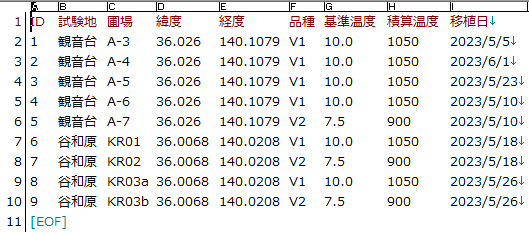

　まず最初に、CSVファイルを読み込みます。このファイルは、チュートリアル６「CSVファイルの読み書き」でも取り扱ったものです。ここでは、読み込んだデータを実際に利用します。

In [17]:
xp = pd.read_csv('6_CSVファイルの読み書き_読み込みサンプル.csv',  # ファイル名
                 encoding='Shift_JIS',   # 文字コード（Excelやネットから取得したものはほぼシフトJIS）
                 parse_dates=['移植日'],  # 日付と理解できる文字列は日付と見なす
                )
xp

,ID,試験地,圃場,緯度,経度,品種,基準温度,積算温度,移植日
0,1,観音台,A-3,36.0260,140.1079,V1,10.0,1050,2023-05-05
1,2,観音台,A-4,36.0260,140.1079,V1,10.0,1050,2023-06-01
2,3,観音台,A-5,36.0260,140.1079,V1,10.0,1050,2023-05-23
3,4,観音台,A-6,36.0260,140.1079,V1,10.0,1050,2023-05-10
4,5,観音台,A-7,36.0260,140.1079,V2,7.5,900,2023-05-10
5,6,谷和原,KR01,36.0068,140.0208,V1,10.0,1050,2023-05-18
6,7,谷和原,KR02,36.0068,140.0208,V2,7.5,900,2023-05-18
7,8,谷和原,KR03a,36.0068,140.0208,V1,10.0,1050,2023-05-26
8,9,谷和原,KR03b,36.0068,140.0208,V2,7.5,900,2023-05-26


### 6.2 栽培条件を網羅する気象データの取得

　次に、これに基づいて、取得する気象データを、個々の予測が必要とするであろう時空間範囲を全て含む形で定めます。

　期間について、開始日は 「移植日」 の列の最小値をとればよいでしょう。メソッド **min** を使えば簡単に取り出せます。取り出された最小値はdatetimeオブジェクトなのでこれを関数 **str** で文字列に変換したうえで初めの10文字を抜き出し体裁を整えます。終了日は一概に決められませんが、9月30日であれば十分でしょう。

In [18]:
itsu = [str(xp['移植日'].min())[:10], '2023-09-30']

print('itsu =', itsu)

itsu = ['2023-05-05', '2023-09-30']


　領域については、全ての試験圃場が含まれる範囲を指定します。「緯度」、「経度」それぞれの列の数値の最小値と最大値を与えればよいでしょう。以下のスクリプトでしめすように、最小値や最大値は、メソッド **min** やメソッド **max** で取り出すことができます。

In [19]:
doko = [xp['緯度'].min(), xp['緯度'].max(), xp['経度'].min(), xp['経度'].max()]

print('doko =', doko)

doko = [36.0068, 36.026, 140.0208, 140.1079]


　この **itsu** と **doko** で、気象データを取得します。 

　なお、「すべての試験圃場が含まれる範囲」として、都府県、ないしは、総合振興局程度の広さを想定しています。本州レベルのスケールの場合は、個々に分割してください。

In [20]:
# 気象データの取得
nani = 'TMP_mea'
data,tim,lat,lon,nam,uni = amd.GetMetData(nani,itsu,doko,namuni=True)

TMP_mea (149, 4, 8) Tile


### 6.3 個々の栽培試験における気象データの取り出し

　取得した気温データは全時空間域をカバーする気象データなので、個々の発育予測においては、それぞれの期間、緯度経度のデータをこの中から取り出さなければなりません。<br>
　numpy.ndarrayオブジェクトの配列は、指定した要素や範囲のデータをインデックスで指定して取り出すことができますが、そのインデックスを見つけるのは結構面倒です。特に、緯度経度に関しては、一般に試験圃場の緯度経度はメッシュの中心緯度とは異なるので、「最も近い」という条件の上で探さなければなりません。このコーディングはとても面倒なので、Python のライブラリ **xarray** の力を借りて行います。<br>
　xarray は、比較的新しいライブラリーですが、地球科学分野を中心に急速に利用が広がっています。多次元データ本体と、それが準拠する時間、緯度、経度、高度などの次元座標、名称、単位などの属性情報を丸ごと保持する **DataArray** オブジェクトを提供し、さらに、解析に便利な多数のメソッドが用意されています。特に、座標値を指定して、一致、あるいは最も近いデータを取り出すメソッド **sel** は大変便利なので、これを利用します。ライブラリ **xarray** の概要については、以下のURLで確認してください。<br>
https://xarray.dev/

　メッシュ農業気象データは、格子点データではなく、メッシュデータですが、データ形式としては格子点データとして扱えるので、DataArray オブジェクトにできます。<br>
　以下を実行すると、**tim**, **lat**, **lon**, **nam**, **uni** とばらばらになっているメッシュデータを一つの、DataArray オブジェクト **mdarr** に纏めることができます。

　実行してください。<br>
　(表示の左上のお皿が重なったようなアイコンをクリックすると表示が畳まれ全体が見やすくなります) 

In [21]:
# 取得した気象データから DataArrayオブジェクト mdarr を作成
mdarr = xr.DataArray(data,    
                     dims=['time','lat','lon'],
                     coords=[('time', tim), ('lat', lat), ('lon', lon)],
                     name=nani,
                     attrs={'long_name':nam,'units':uni},
                    )
mdarr

<xarray.DataArray 'TMP_mea' (time: 149, lat: 4, lon: 8)>
array([[[19.6     , 19.5     , 19.5     , ..., 19.5     , 19.6     ,
         19.6     ],
        [19.6     , 19.5     , 19.5     , ..., 19.5     , 19.6     ,
         19.6     ],
        [19.5     , 19.6     , 19.5     , ..., 19.6     , 19.5     ,
         19.5     ],
        [19.5     , 19.6     , 19.5     , ..., 19.6     , 19.5     ,
         19.6     ]],

       [[22.6     , 22.6     , 22.5     , ..., 22.800001, 23.      ,
         23.1     ],
        [22.6     , 22.5     , 22.6     , ..., 22.9     , 23.      ,
         23.1     ],
        [22.6     , 22.7     , 22.6     , ..., 23.      , 23.1     ,
         23.2     ],
        [22.7     , 22.7     , 22.800001, ..., 23.1     , 23.1     ,
         23.300001]],

       [[15.400001, 15.2     , 15.2     , ..., 15.1     , 15.2     ,
         15.2     ],
...
        [25.4     , 25.4     , 25.4     , ..., 25.6     , 25.6     ,
         25.6     ]],

       [[25.1     , 25.      , 25.      , ..., 25.      , 25.1     ,
         25.1     ],
        [25.1     , 25.      , 25.      , ..., 25.      , 25.1     ,
         25.1     ],
        [25.1     , 25.      , 25.1     , ..., 25.1     , 25.1     ,
         25.2     ],
        [25.      , 25.      , 25.      , ..., 25.2     , 25.2     ,
         25.2     ]],

       [[24.2     , 24.2     , 24.2     , ..., 24.2     , 24.300001,
         24.300001],
        [24.300001, 24.300001, 24.300001, ..., 24.300001, 24.300001,
         24.5     ],
        [24.300001, 24.2     , 24.300001, ..., 24.300001, 24.5     ,
         24.5     ],
        [24.300001, 24.2     , 24.2     , ..., 24.5     , 24.5     ,
         24.5     ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2023-05-05 2023-05-06 ... 2023-09-30
  * lat      (lat) float32 36.0 36.01 36.02 36.03
  * lon      (lon) float32 140.0 140.0 140.0 140.1 140.1 140.1 140.1 140.1
Attributes:
    long_name:  mean air temperature
    units:      Celsius

　これで、気象データは DataArrayオブジェクト **mdarr** となったので、メソッド **sel** を以下のように使用することで、個々の予測計算で必要となる気象データを取り出すことができます。
```Python
mdarr.sel(lat=exlat,lon=exlon,method='nearest').sel(time=slice(extim,None))
```
 これを **for** ループの中に置けば、個々の発育予測に使う気象データが順次得られます。以下でそれを確認できます。

In [22]:
for idx in xp.index:  # Excelで言う行番号でループを回す
    para = list(xp.loc[idx,['基準温度','積算温度']])
    exla = xp.at[idx,'緯度']
    exlo = xp.at[idx,'経度']
    exti = xp.at[idx,'移植日']
    Tarr = mdarr.sel(lat=exla,lon=exlo,method='nearest').sel(time=slice(exti,None)) # 指定した緯度経度に最も近いメッシュの気象データを取り出す
    # 確認のための表示をする文
    print('インデックス', idx, ':')
    print('品種パラメータ：', para)
    print('気象データ：', Tarr.data)
    print()    

インデックス 0 :
品種パラメータ： [10.0, 1050]
気象データ： [19.6      23.300001 15.1      11.7      12.8      16.       15.1
 14.900001 15.3      17.300001 16.1      18.       21.7      24.6
 20.800001 18.7      20.6      20.800001 13.400001 16.5      17.300001
 18.7      20.5      20.6      19.7      21.7      18.4      19.9
 21.1      18.6      19.800001 22.300001 20.300001 21.300001 22.300001
 20.800001 22.300001 20.4      20.300001 23.       22.6      21.1
 23.       24.1      24.800001 22.1      21.4      20.9      18.6
 19.9      23.9      24.7      25.       24.9      25.9      26.1
 26.1      26.       25.7      26.2      24.800001 24.6      24.800001
 27.800001 25.9      27.300001 28.9      28.5      27.4      26.4
 25.5      27.300001 29.7      29.4      29.6      27.300001 26.300001
 25.5      25.300001 25.800001 27.5      28.5      29.4      29.800001
 29.7      29.2      29.800001 29.6      25.1      28.5      29.6
 29.5      29.9      28.2      28.800001 28.6      28.       28.6
 27.9      

　これで、DVSを計算する準備が整いました。

**参考：**　<br>
　上の例では、メッシュデータをAMD_Tools4の関数 **GetMetData** で取り出してからDataArrayオブジェクトにまとめましたが、関数 **GetMetDataX** を以下のように使用すれば、メッシュデータを直接DataArrayオブジェクトとして取得することができます。

```python
mdarr = amd.GetMetDataX(nani,itsu,doko)
```
 

### 6.4 発育予測の逐次実行

　上の **for** ループの中に、発育予測をするDVSを積算する **for** ループをさらに組み込めば,
 個々の試験の条件に応じた発育予測を行うことができます。それは以下のようなものです。

In [23]:
for idx in xp.index:
    para = list(xp.loc[idx,['基準温度','積算温度']])
    exla = xp.at[idx,'緯度']
    exlo = xp.at[idx,'経度']
    exti = xp.at[idx,'移植日']
    Tarr = mdarr.sel(lat=exla,lon=exlo,method='nearest').sel(time=slice(exti,None)) # 指定した緯度経度に最も近いメッシュの気象データを取り出す
    #出穂の計算
    DVS = 0
    for i,Tai in enumerate(Tarr.data):  # 個々の栽培条件におけるi日目の気温がTaiに代入される
        DVS += DVR(Tai, para)   # i日目(が終わった時)におけるDVS
        if DVS > 1.0 : # DVSが1を超えたら
            break      # ループを終了
    # 結果の表示
    print('出穂日: ', Tarr.time[i].data)    

出穂日:  2023-07-28T00:00:00.000000000
出穂日:  2023-08-08T00:00:00.000000000
出穂日:  2023-08-04T00:00:00.000000000
出穂日:  2023-07-29T00:00:00.000000000
出穂日:  2023-07-12T00:00:00.000000000
出穂日:  2023-08-01T00:00:00.000000000
出穂日:  2023-07-16T00:00:00.000000000
出穂日:  2023-08-05T00:00:00.000000000
出穂日:  2023-07-20T00:00:00.000000000


　仕上げに向け、結果を、表示ではなくオブジェクト xp に追加で書き込みます。

In [24]:
xp['出穂日'] = xp['移植日']  # 表xpに列「出穂日」を追加（やっていることは列コピー＆見出し名変更）

for idx in xp.index:
    para = list(xp.loc[idx,['基準温度','積算温度']])
    exla = xp.at[idx,'緯度']
    exlo = xp.at[idx,'経度']
    exti = xp.at[idx,'移植日']
    Tarr = mdarr.sel(lat=exla,lon=exlo,method='nearest').sel(time=slice(exti,None)) # 指定した緯度経度に最も近いメッシュの気象データを取り出す
    #出穂の計算
    DVS = 0
    for i,Tai in enumerate(Tarr.data):
        DVS += DVR(Tai, para)
        if DVS > 1.0 :
            break
    # 表 xp への結果の書き込み
    xp.at[idx,'出穂日'] = str(Tarr.time[i].data)  # 文字列を経由でdatetime64→Timestamp

xp    

,ID,試験地,圃場,緯度,経度,品種,基準温度,積算温度,移植日,出穂日
0,1,観音台,A-3,36.0260,140.1079,V1,10.0,1050,2023-05-05,2023-07-28
1,2,観音台,A-4,36.0260,140.1079,V1,10.0,1050,2023-06-01,2023-08-08
2,3,観音台,A-5,36.0260,140.1079,V1,10.0,1050,2023-05-23,2023-08-04
3,4,観音台,A-6,36.0260,140.1079,V1,10.0,1050,2023-05-10,2023-07-29
4,5,観音台,A-7,36.0260,140.1079,V2,7.5,900,2023-05-10,2023-07-12
5,6,谷和原,KR01,36.0068,140.0208,V1,10.0,1050,2023-05-18,2023-08-01
6,7,谷和原,KR02,36.0068,140.0208,V2,7.5,900,2023-05-18,2023-07-16
7,8,谷和原,KR03a,36.0068,140.0208,V1,10.0,1050,2023-05-26,2023-08-05
8,9,谷和原,KR03b,36.0068,140.0208,V2,7.5,900,2023-05-26,2023-07-20


　上のスクリプトにおいて、1行目の文が「出穂日」を追加する文ですが、少々トリッキーな取り回しなので説明しておきます。pandasのDataFrameでは、代入式の左辺に既存の列が指定されると、その列に右辺の値が代入されますが、新しい列名が指定されるとその名前の列が新規に追加され、そこに右辺の値が代入されます。つまり1行目の文のようにすると、DataFrame **xp** に新しい列「出穂日」が追加され移植日のデータがコピーされます。もちろん、この日付は出穂日ではないのですが、列の追加という目的は達成されました。日付については、11～14 行目で計算され 16 行目の代入文で順次修正されます。<br>

　では最後に、CSVファイルとして出力します。この際、全部の列を書き出すのではなく、いくつかを取捨選択しましょう。
 
　以下を実行してください。

In [25]:
# ファイル出力
xp.to_csv('予測結果.csv',
            columns=['ID','試験地','圃場','品種','移植日','出穂日'], 
            encoding="Shift_JIS",
            index=False)    

ファイル **予測結果.csv** が作られるので、これを開いて内容が以下となっていることを確認してください。

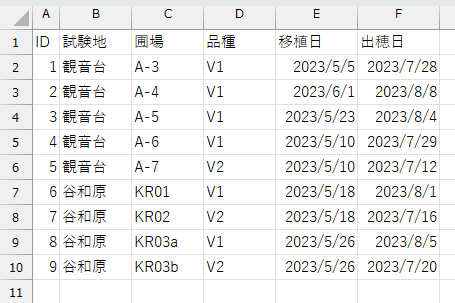

以上で、チュートリアル８「発育の予測」は終わりです。お疲れ様でした。